In [5]:
! pip install neuralprophet


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# package
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df, fill_linear_then_rolling_avg, add_missing_dates_nan


import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

from collections import defaultdict

import copy

import pickle




set_log_level("ERROR")


In [2]:
filepath = '../data/it_history.csv'
df = pd.read_csv(filepath)

In [3]:
df

,Unnamed: 0,GICS Sector,GICS Sub-Industry,Symbol,2012-12-03,2012-12-04,2012-12-05,2012-12-06,2012-12-07,2012-12-10,...,2022-11-18,2022-11-21,2022-11-22,2022-11-23,2022-11-25,2022-11-28,2022-11-29,2022-11-30,2022-12-01,2022-12-02
0,0,Information Technology,Electronic Equipment & Instruments,TRMB,27.695000,27.459999,28.035000,28.365000,28.639999,29.549999,...,57.990002,57.009998,57.779999,58.709999,58.540001,57.459999,56.389999,59.750000,61.119999,61.040001
1,1,Information Technology,Application Software,GEN,7.121276,7.144250,7.224650,7.216992,7.255280,7.167218,...,22.620001,23.049999,23.110001,23.030001,23.110001,23.030001,22.620001,22.959999,23.760000,23.799999
2,2,Information Technology,Data Processing & Outsourced Services,BR,19.284384,19.399508,19.366617,19.506420,19.432398,19.639578,...,144.600006,147.100006,148.360001,148.429993,148.520004,146.500000,142.820007,149.110001,149.860001,148.990005
3,3,Information Technology,Systems Software,FTNT,3.936000,3.986000,3.764000,3.820000,3.940000,4.020000,...,52.150002,52.320000,52.279999,53.349998,52.910000,52.080002,51.590000,53.160000,55.380001,53.610001
4,4,Information Technology,Data Processing & Outsourced Services,FLT,51.930000,51.669998,52.450001,52.450001,52.740002,51.700001,...,188.449997,188.869995,191.399994,189.830002,191.679993,187.309998,190.199997,196.199997,196.279999,193.600006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,61,Information Technology,Semiconductors,MPWR,18.804255,18.813036,18.839375,18.444326,18.417992,18.505775,...,377.309998,368.279999,374.019989,375.690002,369.279999,355.489990,354.950012,381.959991,382.070007,383.209991
62,62,Information Technology,Data Processing & Outsourced Services,GPN,21.273933,21.547924,21.753424,21.738747,21.763212,21.582174,...,98.010002,96.110001,99.180000,100.169998,101.699997,99.769997,99.830002,103.779999,103.529999,103.080002
63,63,Information Technology,Semiconductors,NXPI,22.983027,22.794092,23.134165,22.671293,22.019495,22.501261,...,171.940002,168.850006,173.410004,175.199997,172.690002,164.100006,164.690002,175.839996,173.440002,171.059998
64,64,Information Technology,Electronic Equipment & Instruments,ROP,103.875443,102.894669,104.243233,105.110809,105.403145,105.836937,...,433.010010,434.500000,432.739990,433.619995,436.380005,424.029999,425.250000,438.890015,444.730011,443.869995


In [4]:
# Splitting Process


index_to_symbol = df[['Unnamed: 0', 'Symbol']].to_dict()
symbol_to_index = {index_to_symbol.values(), range(len(index_to_symbol))}



val_num = int(np.round((len(df.columns[4:])*0.15)))
train_num = len(df.columns[4:])-val_num



val = df.iloc[:,4:val_num+4]
train = df.iloc[:,val_num+4:train_num+4]
test = df.iloc[:, train_num+4:]

# train.to_csv('train_daily.csv')
# test.to_csv('test_daily.csv')
# val.to_csv('val_daily.csv')

In [5]:
# Neural Prophet Process

train = train.T
val = val.T
test = test.T



In [6]:
industry_symbol = df['Symbol']

index_to_symbol_map = industry_symbol.to_dict()
symbol_to_index_map = dict(zip(index_to_symbol_map.values(), index_to_symbol_map.keys()))



Setting by Yunseok Jang

주의사항: 이 모델은 변환점을 완벽하게 예측하지는 못함. 본질적으로, 모델만으로 투자를 할경우 단타식으로 하는게 맞다. 장기투자를 하고 싶은 경우, 자신의 전문지식을 동원해서 모델을 사용하는게 올바름.

어떤 방식으로 사용해야하는가?

- 예를들어, 특정 주식 A에 7일예측을 넣는다고 치자. 그리고, 이 주식의 주가가 이때까지 우상향 형태였다고 치자. 이 모델의 예측값은 (관측한 바로는) 그 사이에 예측불가능한 일이 (ex 그 회사의 CEO가 해고당함) 일이 일어나지 않는다는 전제로 함. 따라서, 예측불가능한 일이 터져서 주가가 상승하다가 갑자기 하락하는건 순식간에 캐치를 잘 못함. 7일 이내에 큰일이 안일어난다는 전제로 어느 주식을 사는게 좋을지 대충 정할때는 7일 예측이 괜찮음.
- 1일예측이 가장 정확함. n일을 예측할때 n 이 커질수록 예측 정확도가 점점 당연하게도 안좋아짐.
- 이 모델의 강점은 주가가 꼭대기인지 나락의 끝자락인지 판단을 잘함.
- 아직 튜닝을 완전하게 안해서, 변동폭이 굉장히 클 경우에 정확도가 떨어짐

In [7]:
# AR-NET Implementation
NP = NeuralProphet(
    growth='discontinuous',  
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    trend_reg=0, 
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality=True, # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=30, # To include 7 days worth of AR lag
    num_hidden_layers=4, # 8 hidden layers for the network
    d_hidden=32, # Dimension of hidden layers of AR-Net
    learning_rate=0.01, # Automatically determines learning rate
    epochs=None, # Automatically sets the learning rate (based on data size)
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
)

  0%|          | 0/148 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([519])) that is different to the input size (torch.Size([519, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



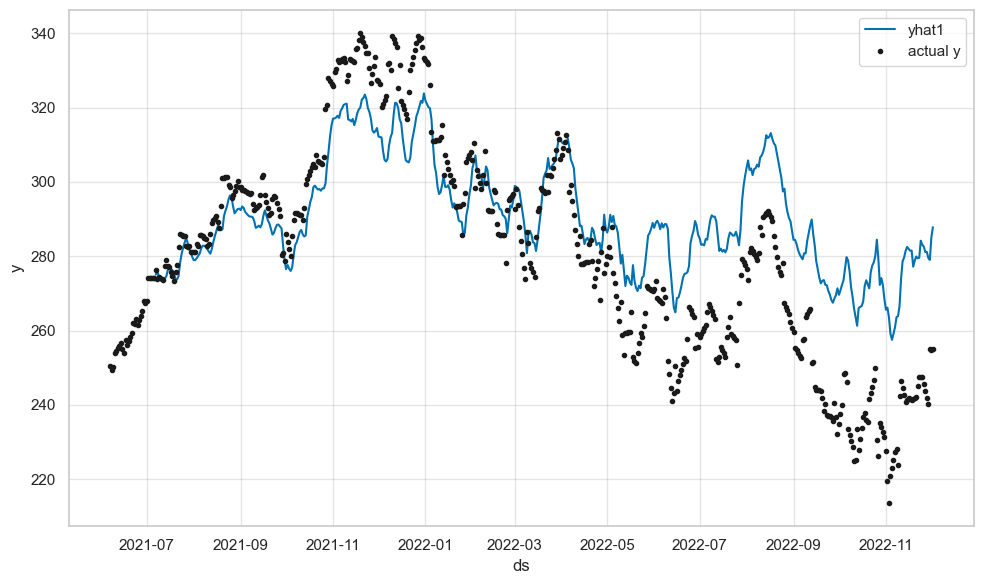

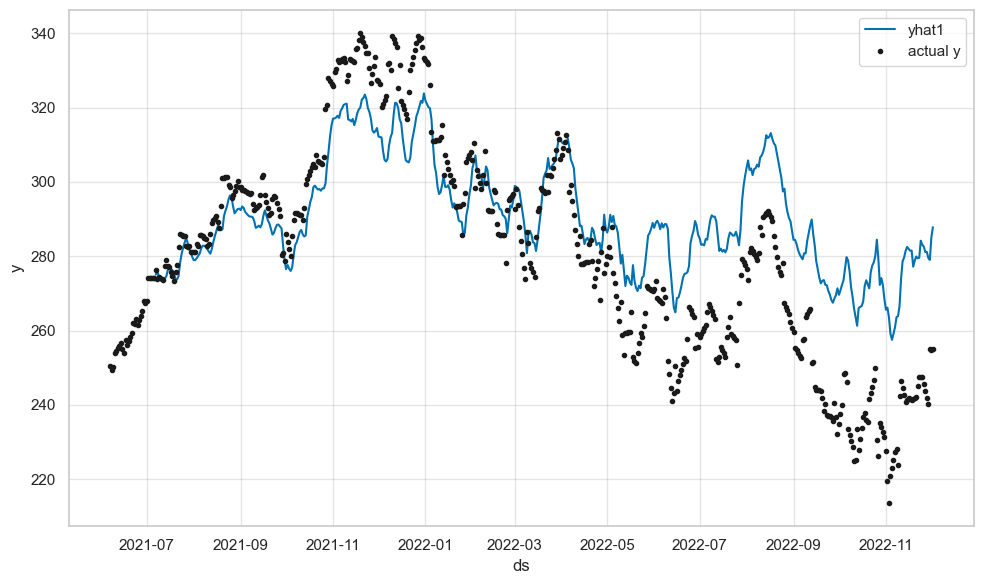

In [8]:


# symbol = industry_symbol[0]
symbol = 'MSFT'

set_random_seed(0)
model = copy.deepcopy(NP)

train_inp = pd.DataFrame(train[symbol_to_index_map[symbol]])
train_inp=train_inp.reset_index()
train_inp=train_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
val_inp = pd.DataFrame(val[symbol_to_index_map[symbol]])
val_inp=val_inp.reset_index()
val_inp=val_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
metrics = model.fit(train_inp,freq="D", validation_df= val_inp)


test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
forecast = model.predict(df=test_inp)

model.plot(forecast)




In [20]:
future = model.make_future_dataframe(df=train_inp, periods= len(test_inp), n_historic_predictions=True)
forecast = model.predict(df=future)
forecast

,ds,y,residual1,yhat1,ar1,trend,season_yearly,season_weekly
0,2014-06-05,35.520187,NaN,None,None,None,None,None
1,2014-06-06,35.752911,NaN,None,None,None,None,None
2,2014-06-07,35.692574,NaN,None,None,None,None,None
3,2014-06-08,35.632236,NaN,None,None,None,None,None
4,2014-06-09,35.571899,NaN,None,None,None,None,None
...,...,...,...,...,...,...,...,...
2553,2021-06-01,244.188248,3.006454,247.194702,105.495972,142.06955,-0.343127,-0.02767
2554,2021-06-02,244.089569,2.87793,246.967499,105.056145,142.132828,-0.26463,0.043157
2555,2021-06-03,242.520203,4.923904,247.444107,105.379204,142.196106,-0.183697,0.052475
2556,2021-06-04,247.534241,-1.322922,246.211319,103.916389,142.259399,-0.100598,0.136124


In [21]:
# forecast['yhat7'][36:]

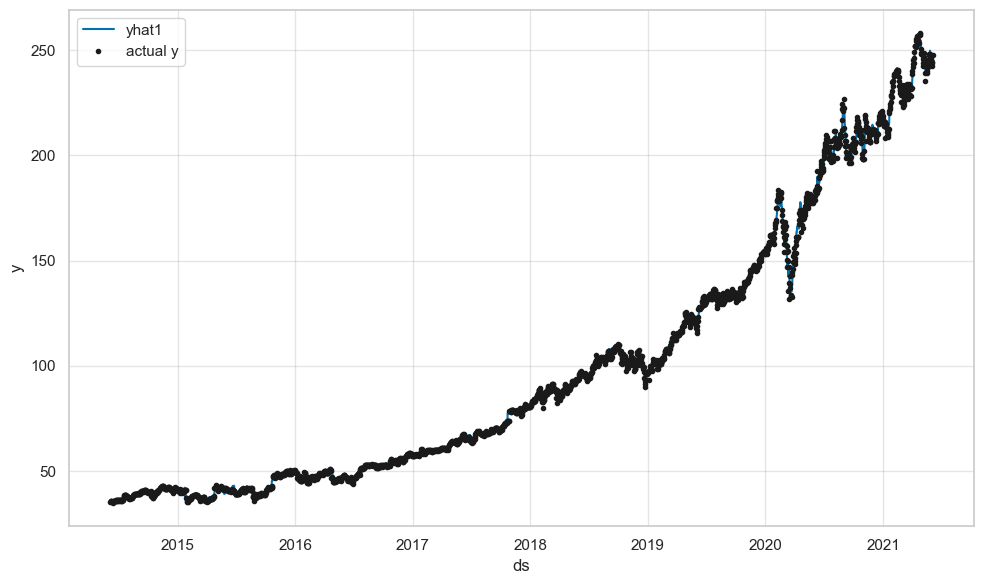

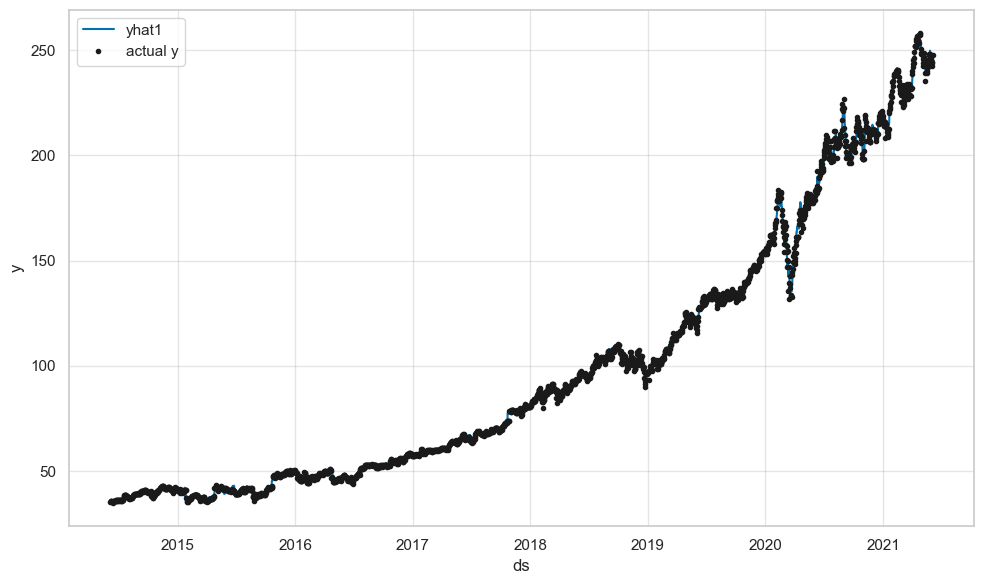

In [22]:
model.plot(forecast)